<a id='beginning_CRVA'></a>
# Climate Risk and Vulnerability Analysis
This notebook helps you download and visualize climate data to perform Climate Risk and Vulnerability analyses

## Usage
this is how to use this script

1. [Define user input](#user_input)
2. [Run wanted climate variables](#climate_variables)
    1. [Atmosphere's climate variables](#atmosphere_climate_variables)
    2. [Land climate's variables](#land_climate_variables)
    3. [Hydrosphere's climate variables](#hydrosphere_climate_variables)
    4. [Second effect's climate variables](#second_effect_climate_variables)
3. [Export data](#Export)

## Input data

* [Shapefile with project location(s) as points or polygon](#load_shapefile)
* List of variables
* List of SSP's
* List of time horizons

## [Climate variables](#climate_variables)
### [Atmosphere's climate variables](#atmosphere_climate_variables)
* [Precipitation](#worldbank)
* [Temperature](#worldbank)
* [Wind](#wind)
* [Humidity](#humidity)
* [Solar radiation](#solar_radiation)
* Air quality deterioration
### [Land's climate variables](#land_climate_variables)
* [Landslides](#landslides)
* Coastal erosion
* Soil erosion
* Soil salinity
### [Hydrosphere's climate variables](#hydrosphere_climate_variables)
* [Relative sea level rise](#relative_sea_level_rise)
* [Seawater temperature](#sea_water_temperature)
* [Water availability](#water_availability)
* floods (fluvial)
* floods (coastal)
* forest fires
### [Second effects of climate variables](#second_effect_climate_variables)
* Storms
* Dust storms
* Wildfire
* Urban heat island
* Growinf season length
* [cyclone risk](#cyclone_risk)



* earthquakes (not climate related)

## Climate impacts
* calculate impact on yields

## [Climate change information concerning the projects in the study area](#climate_change_info_for_each_project_in_study_area)


## Contact

rapy@cowi.com


<a id='user_input'></a>
## User inputs

[Home](#beginning_CRVA)

In [1]:
#User inputs
import os.path


#project locations (shapefile with location of elements to evaluate)
data_folder=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets'
#data_folder=os.path.join(os.pardir,'dataset')
project_location_path=os.path.join(data_folder,'Mozambique_PPIS/EIB_locations_few.shp')
project_id='Name' #name of column used as id

#study boundary (optional)
study_area_path=os.path.join(data_folder,'Mozambique_PPIS/mozambique.shp')

#output folder
#out_path=r'\\COWI.net\projects\A245000\A248363\CRVA\Scripts\outputs'
out_path=r'C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs'

#projection CRS (default = 'EPSG:4326')
bCRS='EPSG:4326'

#buffer for climate/grid variables
buffer=40000 #buffer in meters, 0 = no buffer is computed

mCRS='EPSG:31983' #metric CRS for buffer in meters (find relevant metric CRS for location!)


#### Year of study
#IDEA IS TO GIVE POSSIBILITY FOR THE USER TO CHOOSE DEPENDING on PROJECT (could choose on year or a period but precise period make more sense)
#SET by default for the moment

first_year = 2025 # start year included
last_year = 2026 # last year included


# For data coming from copernicus, historical data are commonly 1850-2005

## Import python packages

In [2]:
#Import python packages
from rasterstats import zonal_stats
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import show
import rioxarray #used when calling ncdata.rio.write_crs
import xarray as xr
import os
import os.path
import matplotlib.pyplot as plt
import netCDF4 as nc#not directly used but needs to be imported for some nc4 files manipulations, use for nc files
from netCDF4 import Dataset
import csv #REMOVE ? not in use ?
import numpy as np
import numpy.ma as ma
from mpl_toolkits.basemap import Basemap
import shutil # to move folders
import warnings
warnings.filterwarnings('ignore') # to ignore the warnings
#import io
import cdsapi # for copernicus function
import datetime # to have actual date
from osgeo import gdal, ogr, osr # in order to convert shp in raster
from geopandas import GeoDataFrame
from shapely.geometry import Point
from matplotlib.lines import Line2D

# to perform bias correction
from bias_correction import BiasCorrection, XBiasCorrection
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import gamma, norm
from scipy.signal import detrend

# import functions and class defined in another file named FunctionsAndClass
## Functions
from FunctionsAndClass import copernicus_data
from FunctionsAndClass import year_copernicus
from FunctionsAndClass import date_copernicus
from FunctionsAndClass import csv_copernicus
from FunctionsAndClass import Display_map
from FunctionsAndClass import read_cckp_ncdata
from FunctionsAndClass import get_cckp_file_name
from FunctionsAndClass import Display_map_projects
from FunctionsAndClass import register_data # import to test
from FunctionsAndClass import find_column_name # import to test
from FunctionsAndClass import search_for_nc # import to test
from FunctionsAndClass import try_download_copernicus # import to test


## Class
from FunctionsAndClass import calendar
from FunctionsAndClass import copernicus_elements
from FunctionsAndClass import map_elements

C:\Users\CLMRX\AppData\Local\Temp\1\ipykernel_226936\3509116232.py:4: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


<a id='load_shapefile'></a>
## Load shapefiles and plot

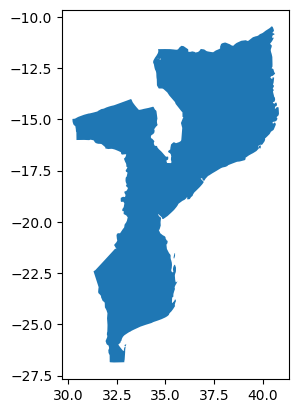

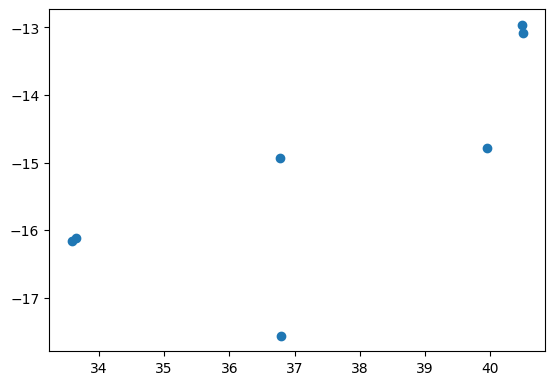

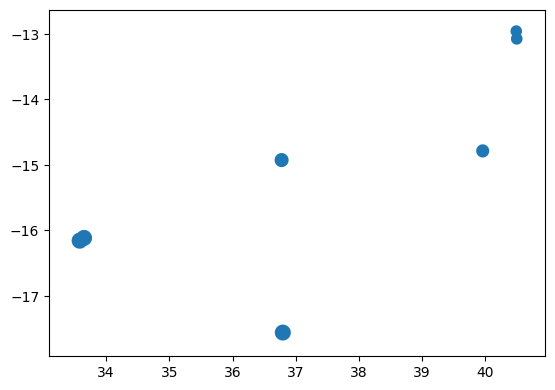

In [3]:
#load shapefiles
projects = gpd.read_file(project_location_path).to_crs(bCRS)
study_area = gpd.read_file(study_area_path).to_crs(bCRS)

#calculate buffer around points/shape
if buffer != 0:
    projects_buf=projects.to_crs(mCRS)  #project to crs with metric units to get buffer in meters
    projects_buf['geometry']=projects.to_crs(mCRS).buffer(buffer) #assign the buffer as the new geometry - 
    projects_buf=projects_buf.to_crs(bCRS)#project back to orginal crs

    
#plot shapefiles
study_area.plot()
projects.plot()
projects_buf.plot() 


#show table
projects[[project_id]]

# register geographic information concerning projects
lon_projects = projects['geometry'].x
lat_projects = projects['geometry'].y
area_projects = [lat_projects - 5, lat_projects+5, lon_projects-5,lon_projects+5] # list format
# 5 degres trop grand 
#### determination of the geographical zone of interest 
lat_min_wanted = min(study_area['LAT'])-10
lat_max_wanted = max(study_area['LAT'])+10
lon_min_wanted = min(study_area['LON'])-20
lon_max_wanted = max(study_area['LON'])+20
# addind and substracting to lon and lat to have margin
# substracting more to longitude because the range of longitude is -180 to 180. The range of latitude is -90 to 90

area = [lat_min_wanted, lon_min_wanted, lat_max_wanted,lon_max_wanted,] # used to download from copernicus

### YEAR
year = np.arange(first_year,(last_year+1),1) # create vector of years
year_str = [0]*len(year) # create initiale empty vector to convert years in int
index = np.arange(0,len(year)) # create vector of index for year
i = 0 # initialize index
for i in index: # convert all the date in string format
    year_str[i]=str(year[i])

start_date = "01-01-"+year_str[0] # string start date based on start year
stop_date = "31-12-"+year_str[len(year)-1] # string stop date based on stop year
dates = pd.date_range(start_date,stop_date) # vector of dates between start date and stop date
index_dates = np.arange(0,len(dates)) # vector containning index o dates vector

In [ ]:
base = study_area.plot(color='white', edgecolor='black')
projects.plot(ax=base, marker='o', color='blue', markersize=5);

In [ ]:
library(NASAaccess)

NEX_GDDP_CMIP6(Dir = "./NEX_GDDP_CMIP6/", 
               watershed = shape_path,
              dem_path,  
              start = "2060-12-1", 
              end = "2060-12-3",
              model = 'ACCESS-CM2', 
              type = 'tas', 
              slice = 'ssp245')

In [ ]:
import requests

filepath = 'https://ds.nccs.nasa.gov/thredds2/fileServer/AMES/NEX/GDDP-CMIP6/ACCESS-CM2/historical/r1i1p1f1/hurs/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950.nc'


In [ ]:
import csv
import os
import hashlib
import logging
from subprocess import run as srun
from urllib.parse import urlparse
logging.basicConfig(level=logging.INFO)
def download(uri, ofile, md5):
    srun(['curl', '-s', '-o', ofile, uri], capture_output=True, check=True) # without curl, file is corrupted
    md5dld = str(hashlib.md5(open(ofile, 'rb').read()).hexdigest())
    if md5 != md5dld:
        logging.warning("%s != %s", md5, md5dld)
    logging.info("uri %s (%s == %s) : %s", uri, md5, md5dld, ofile)

with open('gddp-cmip6-thredds-fileserver.csv') as index:
    fobjects = csv.reader(index)
    next(fobjects)
    next(fobjects)
    next(fobjects)
    next(fobjects)
    for objs in fobjects:
        md5, uri = [o.strip() for o in objs]
        prsout = urlparse(uri)
        ofile = os.path.split(prsout.path)[1]
        download(uri, ofile, md5)

In [ ]:
os.path.isfile('hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950.nc')

In [ ]:
Dataset("hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950.nc", format='NETCDF4_CLASSIC')

In [ ]:
import gc
import os

import click
import pandas as pd
import xarray as xr
from xsd.bcsd import bcsd, disagg



<a id='climate_variables'></a>
# Climate variables

[Home](#beginning_CRVA)

<a id='atmosphere_climate_variables'></a>
# ATMOSPHERE

[Home](#beginning_CRVA)

<a id='worldbank'></a>
## World Bank Climate knowledge portal, Precipitation and Temperature - Atmosphere
data source: https://climateknowledgeportal.worldbank.org/download-data

List of different variables:

### Precipitation 
* return period of current 50 and 100 year event
* yearly average precipitation
* seasonal average precipitation - OR MONTH? i word documnet: average dry season precipitation 
* maximum precipitation in one day - NOT REALLY, instead "Average of the largest daily precipitation amount" rx1day 
* maximum precipitation in five days - NOT REALLY, instead "Average of the largest 5-day consecutive precipitation amount".
* FORSLAG: Could also include: precipitation amount from very wet days/ days >50mm. eg. 

### Temperature
* Yearly mean temperature (average) - tas 
* Number of hot days >40 degrees C (average)
* Number of hot days >35 degrees C (average) 
* Maximum of daily max-temperature (per year) -txx
* Average of maximum temperature (daily??) - tasmax 

### How to use
define 

`variables = {variablename1:{'periods':['2020-2039'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']}, variablename2:...}`

where variablename corresponds to a variable name in the cckp, periods include the desired periods, ssps the desired ssp-rcp scenarios, and gcms can be either median, p10, or p90 (50%, 10%, and 90% percentile of ensemble models).

In [ ]:
#Read downloaded precipitation and temperature data
#settings

variables= {
    #Temperature
        #era/cru
            #'climatology-hd35-annual-mean_era':{'periods':['1991-2020']},
            'climatology-hd40-annual-mean_era':{'periods':['1991-2020']},
            'climatology-tasmax-annual-mean_era':{'periods':['1991-2020']}, 
            'climatology-tas-annual-mean_era':{'periods':['1991-2020']},
            'climatology-tasmax-annual-mean_cru':{'periods':['1991-2020']}, 
        #realtime
            'climatology-hd40':{'periods':['2020-2039'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'anomaly-hd40':{'periods':['2020-2039'],'ssps':['ssp245','ssp370'],'gcms':['median']},
            #'anomaly-hd35':{'periods':['2020-2039'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            #'anomaly-tasmax':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']}, 
            'anomaly-txx':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']}, #txx=maximum of daily max temperature
            'climatology-txx':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'anomaly-tas':{'periods':['2020-2039'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'climatology-tas':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']}, #data not downloaded 
    #Precipitation
       #era/cru
            #'climatology-r50mm-annual-mean_era_annual':{'periods':['1991-2020']},
            'climatology-rx1day-monthly-mean_era_monthly':{'periods':['1991-2020']},
            'climatology-rx1day-annual-mean_era_annual':{'periods':['1991-2020']},
            'climatology-pr-annual-mean_era_annual':{'periods':['1991-2020']},
            'climatology-pr-monthly-mean_era_monthly':{'periods':['1991-2020']},
            'climatology-pr-annual-mean_cru':{'periods':['1991-2020']},
        #realtime
            'frp100yr-rx1day-period-mean_cmip6_period':{'periods':['2010-2039','2035-2064'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']}, 
            'frp50yr-rx1day-period-mean_cmip6_period':{'periods':['2010-2039'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'climatology-rx5day-annual-mean_cmip6_annual':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'climatology-rx1day-annual-mean_cmip6_annual':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'climatology-pr-monthly-mean_cmip6_monthly':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'climatology-pr-annual-mean_cmip6_annual':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'climatology-pr-seasonal-mean_cmip6_seasonal':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'changefactorfaep100yr-rx1day-period-mean_cmip6_period':{'periods':['2010-2039'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            #'anomaly-pr-monthly-mean_cmip6_monthly':{'periods':['2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']}
            }
       ## 'timeseries-rx1day':{'periods':['2015-2100'],'ssps':['ssp245'],'gcms':['median']} # Den kan ikke læse den - brokker sig over Dimension time=0. 
       
#Create multi index for cckp_output
idx=pd.IndexSlice
mindex=[]
for var in variables.keys():
    for period in variables[var]['periods']:
        if period in ['1991-2020']:
            mindex.append((var,period,None,None))
        else:
            for ssp in variables[var]['ssps']:
                    for gcm in variables[var]['gcms']:
                        mindex.append((var,period,ssp,gcm))
mindex=pd.MultiIndex.from_tuples(mindex, names=['variable', 'period','ssp','gcm'])
#cckp_output=pd.DataFrame(index=projects[project_id],columns=mindex)
cckp_output=pd.DataFrame(index=mindex,columns=projects[project_id])

#read data from cckp and spatial statistics
for var in variables.keys():
    for period in variables[var]['periods']:
        if period in ['1991-2020']: # for era/cru data
            varname='_'.join((var,period))
            data_path=get_cckp_file_name(var,period=period)
            if os.path.exists(data_path):
                data=read_cckp_ncdata(data_path)
                stats=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=data,all_touched=True, stats='mean'))
                projects[varname]=stats
                #cckp_output.loc[:,idx[var,period,:,:]]=stats.values
                cckp_output.loc[idx[var,period,:,:],:]=stats.T.values
            else:
                print(data_path,"not found")
                projects[varname]='not found'
        elif period not in ['1991-2020']: #for realtime data 
                for ssp in variables[var]['ssps']:
                    for gcm in variables[var]['gcms']:
                        varname='_'.join((var,period,ssp,gcm))
                        data_path=get_cckp_file_name(var,ssp=ssp,period=period,gcm=gcm)
                        if os.path.exists(data_path):
                            data=read_cckp_ncdata(data_path)
                            stats=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=data,all_touched=True, stats='mean'))
                            projects[varname]=stats
                            #cckp_output.loc[:,idx[var,period,ssp,gcm]]=stats.values
                            cckp_output.loc[idx[var,period,ssp,gcm],:]=stats.T.values
                        else:
                            print(data_path,"not found")
                            projects[varname]='not found'


#plot, show #ADD enlarge the clip + something wierd with nodata value
cckp_output.to_csv('outputs/csv/cckp_output.csv')
projects[[project_id,varname]].head()

fig, ax = plt.subplots()
precip = rioxarray.open_rasterio(data)
precip_clip = precip.rio.clip(study_area.geometry, study_area.crs, drop=True)
precip_clip.plot(ax=ax)
projects.plot(ax=ax)

#close
precip.close()

<a id='wind'></a>
## Wind Speed

Daily wind speed, historical and projected.

Data source : https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=form

In [ ]:
### Extraction of Near-surface wind speed data
global_variable = 'Wind'
name_variable = 'near_surface_wind_speed'

#### Historical data for wind speed

In [ ]:
(year_historical, year_str_historical, index_historical)=year_copernicus(1950,2014)
temporal_resolution = 'daily'
# Register data from copernicus for humidity in a dataframe and production of a csv file for the period indicated above
(Wind_historical,period_historical) = dataframe_csv_copernicus(temporal_resolution,year_str_historical,copernicus_elements.experiments_historical,copernicus_elements.models,out_path, name_variable,'sfcWind',area)    

#### Projection data for wind speed

In [ ]:
(year, year_str, index)=year_copernicus(2098,2099)
temporal_resolution = 'daily'

#(df,period) = dataframe_csv_copernicus(temporal_resolution,year_str,copernicus_elements.experiments,copernicus_elements.models,out_path,global_variable, name_variable,'sfcWind',projects.Name[0],[area_projects[0][0],area_projects[1][0],area_projects[2][0],area_projects[3][0]])

# df with separation of different projects
# separate dataframe function
NameProjects=list(projects['Name'])
#NameProjects.remove('PT1_Pemba - Breidge Paquite')

# Register data from copernicus for humidity in a dataframe and production of a csv file for the period indicated above
k=0
Temp=[]
for name_project in NameProjects:
    (df,period) = dataframe_csv_copernicus(temporal_resolution,year_str,copernicus_elements.experiments,copernicus_elements.models,out_path,global_variable, name_variable,name_project,[area_projects[0][k],area_projects[1][k],area_projects[2][k],area_projects[3][k]])  
    Temp.append(df)
    k+=1
# last parameter is the area of one project, elements are fisrt col (min lat = 0, max lat = 1, min lon = 0, max lon = 1), then line (each ligne is coordinates for a project)

In [ ]:
(year, year_str, index)=year_copernicus(2098,2099)
temporal_resolution = 'daily'
### does not work for PT1_Pemba - Breidge Paquite. When extract all, try to extract a json file (no need for it I think)
### this makes everything going bad
(df,period) = dataframe_csv_copernicus(temporal_resolution,year_str,copernicus_elements.experiments,copernicus_elements.models,out_path,global_variable, name_variable,'sfcWind','PT_ Dumping Site',[area_projects[0][6],area_projects[1][6],area_projects[2][6],area_projects[3][6]])

In [ ]:
projects['Name']

In [ ]:
df

In [ ]:
### BOXPLOTS


df_reordered2 = df.reorder_levels(['Experiment', 'Model', 'Latitude', 'Date']) # reordering to ...
df_reordered2_mean=df_reordered2.groupby(level=[0,1,2],axis=0,group_keys=True).mean()
numpy_array = df_reordered2_mean.loc['ssp1_2_6','access_cm2'].values
numpy_array=numpy_array.flatten() # make the array a vector to use it in boxplot function
numpy_array1 = numpy_array[~np.isnan(numpy_array)]

numpy_array = df_reordered2_mean.loc['ssp1_2_6','awi_cm_1_1_mr'].values
numpy_array=numpy_array.flatten() # make the array a vector to use it in boxplot function
numpy_array2 = numpy_array[~np.isnan(numpy_array)]

numpy_array = df_reordered2_mean.loc['ssp1_2_6','bcc_csm2_mr'].values
numpy_array=numpy_array.flatten() # make the array a vector to use it in boxplot function
numpy_array3 = numpy_array[~np.isnan(numpy_array)]
# boxplot do not deal with NaN, have to take them out
dict_boxplot = plt.boxplot([numpy_array1,numpy_array2,numpy_array3],notch=True, whis =(10,90),widths = 0.15, patch_artist=True,labels=('access_cm2','awi_cm_1_1_mr','bcc_csm2_mr'))#,labels = 'access_cm2')# ... present boxplot over the period for each models
# this functions returns varius parameters of the boxplot in the dict_boxplot. This funcitons also returns an image of it
# here, numpy_array is a vector. But can also include array with several columns. Each columns will have a boxplot
# 'notch' is true to enhance part where the median is
# 'whis' is the percentile value for the whiskers, every data out of the range indicted by those 2 floats are represented as points
# 'widths' determine width of the boxes
# 'patch_artist' colors the boxplots
# 'labels' gives a name to every column included in the data part
str = 'Distribution of the average daily wind speed for different models \nfor the year '+period+' and under scenario ssp1_2_6'
title_png = 'Boxplot_models_ssp1_2_6'
plt.title(str)
plt.xlabel('Models')
plt.ylabel('Average wind speed m/s')
plt.savefig(os.path.join(out_path,'figures','Boxplots',title_png),format ='png') # savefig or save text must be before plt.show. for savefig, format should be explicity written
plt.show()

In [ ]:
#### BOXPLOTS


df_reordered3 = df.reorder_levels(['Experiment', 'Model', 'Latitude', 'Date']) # reordering to ...
df_reordered3_mean=df_reordered3.groupby(level=[0,1,2],axis=0,group_keys=True).mean()
numpy_array = df_reordered3_mean.loc['ssp1_2_6'].values
numpy_array=numpy_array.flatten() # make the array a vector to use it in boxplot function
numpy_array4 = numpy_array[~np.isnan(numpy_array)]
# boxplot do not deal with NaN, have to take them out
dict_boxplot = plt.boxplot(numpy_array4,notch=True, whis =(10,90),widths = 0.15, patch_artist=True,labels=('ssp1_2_6',))# ... present boxplot over the period for each models
# this functions returns varius parameters of the boxplot in the dict_boxplot. This funcitons also returns an image of it
# here, numpy_array is a vector. But can also include array with several columns. Each columns will have a boxplot
# 'notch' is true to enhance part where the median is
# 'whis' is the percentile value for the whiskers, every data out of the range indicted by those 2 floats are represented as points
# 'widths' determine width of the boxes
# 'patch_artist' colors the boxplots
# 'labels' gives a name to every column included in the data part
str = 'Distribution of the average daily wind speed accross models\nfor the year 2099-2100 and under scenario ssp1_2_6'
title_png = 'Boxplot_ssp1_2_6'
plt.title(str)
plt.xlabel('Models')
plt.ylabel('Average wind speed m/s')
plt.savefig(os.path.join(out_path,'figures','Boxplots',title_png),format ='png') # savefig or save text must be before plt.show. for savefig, format should be explicity written
plt.show()

<a id='humidity'></a>
## Humidity

Source : https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=form

### Relative humidity

Relative humidity of air: amount if moisture it contains compared to the maximum amount of moisture it can have at a specific temperature

### Extraction of Relative humidity data

In [ ]:
global_variable = 'Relative_Humidity'
name_variable = 'near_surface_relative_humidity' # only available on a monthly basis

#### Historical data

In [ ]:
(year_historical, year_str_historical, index_historical) = year_copernicus(1850,2014)
temporal_resolution = 'monthly'

# Register data from copernicus for humidity in a dataframe and production of a csv file for the period indicated above
Humidity_historical = dataframe_csv_copernicus(temporal_resolution,year_str_historical,copernicus_elements.experiments_historical,copernicus_elements.models,out_path,global_variable, name_variable,area)    

#### Projections

In [ ]:
(year, year_str, index) = year_copernicus(2020,2100)
temporal_resolution = 'monthly'

# Register data from copernicus for humidity in a dataframe and production of a csv file for the period indicated above
Humidity = dataframe_csv_copernicus(temporal_resolution,year_str,copernicus_elements.experiments,copernicus_elements.models,out_path,global_variable, name_variable,area)    

<a id='solar_radiation'></a>
## Solar radiation

In [4]:
global_variable = 'Solar_radiation'
# choose of the climate variable from copernicus to represent : choose of surface_downwelling_shortwave_radiation because
# 1. interest for project located at the surface of the Earth
# 2. for most project (for example solar panels), we are interest in radiation going down, not up
# 3. Shortwave radiation are the ones produce by the sun
name_variable = 'surface_downwelling_shortwave_radiation' # only available on a monthly basis

#### Historical data for solar radiation

In [ ]:
(year_historical, year_str_historical, index_historical)=year_copernicus(1850,2016)
temporal_resolution = 'monthly'
# Register data from copernicus for humidity in a dataframe and production of a csv file for the period indicated above
Solar_radiation_historical = dataframe_csv_copernicus(temporal_resolution,year_str_historical,copernicus_elements.experiments_historical,copernicus_elements.models,out_path,global_variable, name_variable,area)    

#### Projection for data solar radiation

In [ ]:
(year, year_str, index)=year_copernicus(2016,2099)
temporal_resolution = 'monthly'

Projections_solar_radiation_projects = pd.DataFrame() # create an empty dataframe
for (name_project,k) in zip(projects['Name'],np.arange(0,len(projects['Name']))):
    (df,period) = csv_copernicus(temporal_resolution,year_str,copernicus_elements.experiments,copernicus_elements.models,out_path,global_variable, name_variable,name_project,[area_projects[0][k],area_projects[1][k],area_projects[2][k],area_projects[3][k]],'CMIP6-copernicus-GCM')  
    Projections_solar_radiation_projects = pd.concat([Projections_solar_radiation_projects,df])
path_for_csv = os.path.join(out_path,'csv','data',name_variable)
Projections_solar_radiation_projects.to_csv('outputs/csv/data/Projections_solar_radiation_projects.csv')

############################### Project name: PT_Revubue 2 (Rev 2/01) ###############################
FUNCTION DATAFRAME_COPERNICUS
Test with scenario ssp1_1_9
Test with model access_cm2
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 16:35:57,679 INFO Welcome to the CDS
2023-05-16 16:35:57,680 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-16 16:35:57,725 INFO Request is queued
2023-05-16 16:35:58,763 INFO Request is failed
2023-05-16 16:35:58,764 ERROR Message: an internal error occurred processing your request
2023-05-16 16:35:58,764 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'ACCESS-CM2', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 16:35:58,765 ERROR   Traceback (most recent call last):
2023-05-16 16:35:58,766 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 16:35:58,767 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 16:35:58,768 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 16:35:58,769 ERROR       result = proc(conte

Some parameters are not matching

No value were found for the period and the project tested

Test with model awi_cm_1_1_mr
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 16:35:59,901 INFO Request is failed
2023-05-16 16:35:59,902 ERROR Message: an internal error occurred processing your request
2023-05-16 16:35:59,902 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'AWI-CM-1-1-MR', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 16:35:59,903 ERROR   Traceback (most recent call last):
2023-05-16 16:35:59,903 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 16:35:59,905 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 16:35:59,907 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 16:35:59,907 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-16 16:35:59,907 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-16 16:35:59,910 ERROR       return p(*args, **kwar

Some parameters are not matching

No value were found for the period and the project tested

Test with model bcc_csm2_mr
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 16:36:01,090 INFO Request is failed
2023-05-16 16:36:01,091 ERROR Message: an internal error occurred processing your request
2023-05-16 16:36:01,091 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'BCC-CSM2-MR', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 16:36:01,093 ERROR   Traceback (most recent call last):
2023-05-16 16:36:01,094 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 16:36:01,095 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 16:36:01,096 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 16:36:01,097 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-16 16:36:01,098 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-16 16:36:01,099 ERROR       return p(*args, **kwargs

Some parameters are not matching

No value were found for the period and the project tested

Test with model cams_csm1_0
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\PT_Revubue 2 (Rev 2_01)\ssp1_1_9\cams_csm1_0\2016-2099\CMIP6-copernicus-GCM\rsds_Amon_CAMS-CSM1-0_ssp119_r1i1p1f1_gn_20160116-20991216_v20190708.nc

 The final path for nc file exists ? False

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\PT_Revubue 2 (Rev 2_01)\ssp1_1_9\cams_csm1_0\2016-2099\CMIP6-copernicus-GCM\rsds_Amon_CAMS-CSM1-0_ssp119_r1i1p1f1_gn_20160116-20991216_v20190708.nc

 The final path for nc file exists ? True

Registering the data in a datafra

2023-05-16 16:36:23,009 INFO Welcome to the CDS
2023-05-16 16:36:23,010 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-16 16:36:23,057 INFO Request is queued



Value were found for the period and the project tested

Test with model canesm5_canoe
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 16:36:24,098 INFO Request is failed
2023-05-16 16:36:24,098 ERROR Message: an internal error occurred processing your request
2023-05-16 16:36:24,099 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'CanESM5-CanOE', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 16:36:24,100 ERROR   Traceback (most recent call last):
2023-05-16 16:36:24,101 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 16:36:24,102 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 16:36:24,102 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 16:36:24,104 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-16 16:36:24,104 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-16 16:36:24,105 ERROR       return p(*args, **kwar

Some parameters are not matching

No value were found for the period and the project tested

Test with model cesm2_fv2
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 16:36:25,284 INFO Request is failed
2023-05-16 16:36:25,285 ERROR Message: an internal error occurred processing your request
2023-05-16 16:36:25,285 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'CESM2-FV2', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 16:36:25,286 ERROR   Traceback (most recent call last):
2023-05-16 16:36:25,287 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 16:36:25,288 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 16:36:25,289 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 16:36:25,290 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-16 16:36:25,290 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-16 16:36:25,292 ERROR       return p(*args, **kwargs)


Some parameters are not matching

No value were found for the period and the project tested

Test with model cesm2_waccm_fv2
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 16:36:26,421 INFO Request is failed
2023-05-16 16:36:26,422 ERROR Message: an internal error occurred processing your request
2023-05-16 16:36:26,422 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'CESM2-WACCM-FV2', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 16:36:26,423 ERROR   Traceback (most recent call last):
2023-05-16 16:36:26,424 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 16:36:26,426 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 16:36:26,426 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 16:36:26,427 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-16 16:36:26,427 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-16 16:36:26,428 ERROR       return p(*args, **kw

Some parameters are not matching

No value were found for the period and the project tested

Test with model cmcc_cm2_hr4
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 16:36:27,579 INFO Request is failed
2023-05-16 16:36:27,580 ERROR Message: an internal error occurred processing your request
2023-05-16 16:36:27,582 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'CMCC-CM2-HR4', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 16:36:27,583 ERROR   Traceback (most recent call last):
2023-05-16 16:36:27,586 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 16:36:27,587 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 16:36:27,588 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 16:36:27,589 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-16 16:36:27,590 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-16 16:36:27,591 ERROR       return p(*args, **kwarg

Some parameters are not matching

No value were found for the period and the project tested

Test with model cmcc_esm2
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 16:36:28,720 INFO Request is failed
2023-05-16 16:36:28,722 ERROR Message: an internal error occurred processing your request
2023-05-16 16:36:28,722 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'CMCC-ESM2', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 16:36:28,723 ERROR   Traceback (most recent call last):
2023-05-16 16:36:28,723 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 16:36:28,724 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 16:36:28,725 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 16:36:28,725 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-16 16:36:28,727 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-16 16:36:28,727 ERROR       return p(*args, **kwargs)


Some parameters are not matching

No value were found for the period and the project tested

Test with model cnrm_cm6_1_hr
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 16:36:29,844 INFO Request is failed
2023-05-16 16:36:29,845 ERROR Message: an internal error occurred processing your request
2023-05-16 16:36:29,846 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'CNRM-CM6-1-HR', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 16:36:29,847 ERROR   Traceback (most recent call last):
2023-05-16 16:36:29,849 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 16:36:29,850 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 16:36:29,850 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 16:36:29,852 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-16 16:36:29,853 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-16 16:36:29,853 ERROR       return p(*args, **kwar

Some parameters are not matching

No value were found for the period and the project tested

Test with model e3sm_1_0
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 16:36:30,974 INFO Request is failed
2023-05-16 16:36:30,975 ERROR Message: an internal error occurred processing your request
2023-05-16 16:36:30,976 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'E3SM-1-0', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 16:36:30,977 ERROR   Traceback (most recent call last):
2023-05-16 16:36:30,978 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 16:36:30,978 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 16:36:30,979 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 16:36:30,980 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-16 16:36:30,982 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-16 16:36:30,983 ERROR       return p(*args, **kwargs)
2

Some parameters are not matching

No value were found for the period and the project tested

Test with model e3sm_1_1_eca
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 16:36:32,125 INFO Request is failed
2023-05-16 16:36:32,125 ERROR Message: an internal error occurred processing your request
2023-05-16 16:36:32,126 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'E3SM-1-1-ECA', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 16:36:32,127 ERROR   Traceback (most recent call last):
2023-05-16 16:36:32,127 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 16:36:32,128 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 16:36:32,129 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 16:36:32,130 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-16 16:36:32,131 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-16 16:36:32,131 ERROR       return p(*args, **kwarg

Some parameters are not matching

No value were found for the period and the project tested

Test with model ec_earth3_aerchem
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 16:36:33,268 INFO Request is failed
2023-05-16 16:36:33,269 ERROR Message: an internal error occurred processing your request
2023-05-16 16:36:33,270 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'EC-Earth3-AerChem', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 16:36:33,271 ERROR   Traceback (most recent call last):
2023-05-16 16:36:33,271 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 16:36:33,272 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 16:36:33,272 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 16:36:33,273 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-16 16:36:33,274 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-16 16:36:33,274 ERROR       return p(*args, **

Some parameters are not matching

No value were found for the period and the project tested

Test with model ec_earth3_veg
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\PT_Revubue 2 (Rev 2_01)\ssp1_1_9\ec_earth3_veg\2016-2099\CMIP6-copernicus-GCM\rsds_Amon_EC-Earth3-Veg_ssp119_r1i1p1f1_gr_20160116-20991216_v20200226.nc

 The final path for nc file exists ? False

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\PT_Revubue 2 (Rev 2_01)\ssp1_1_9\ec_earth3_veg\2016-2099\CMIP6-copernicus-GCM\rsds_Amon_EC-Earth3-Veg_ssp119_r1i1p1f1_gr_20160116-20991216_v20200226.nc

 The final path for nc file exists ? True

Registering the data in

2023-05-16 16:37:56,771 INFO Welcome to the CDS
2023-05-16 16:37:56,772 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-16 16:37:56,817 INFO Request is queued
2023-05-16 16:37:57,852 INFO Request is failed
2023-05-16 16:37:57,853 ERROR Message: an internal error occurred processing your request
2023-05-16 16:37:57,854 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'FGOALS-f3-L', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 16:37:57,855 ERROR   Traceback (most recent call last):
2023-05-16 16:37:57,856 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 16:37:57,856 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 16:37:57,857 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 16:37:57,859 ERROR       result = proc(cont

Some parameters are not matching

No value were found for the period and the project tested

Test with model fio_esm_2_0
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 16:37:58,985 INFO Request is failed
2023-05-16 16:37:58,986 ERROR Message: an internal error occurred processing your request
2023-05-16 16:37:58,987 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'FIO-ESM-2-0', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 16:37:58,988 ERROR   Traceback (most recent call last):
2023-05-16 16:37:58,988 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 16:37:58,989 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 16:37:58,990 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 16:37:58,991 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-16 16:37:58,991 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-16 16:37:58,992 ERROR       return p(*args, **kwargs

Some parameters are not matching

No value were found for the period and the project tested

Test with model giss_e2_1_g
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\PT_Revubue 2 (Rev 2_01)\ssp1_1_9\giss_e2_1_g\2016-2099\CMIP6-copernicus-GCM\rsds_Amon_GISS-E2-1-G_ssp119_r1i1p1f2_gn_20160116-20991216_v20200115.nc

 The final path for nc file exists ? False

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\PT_Revubue 2 (Rev 2_01)\ssp1_1_9\giss_e2_1_g\2016-2099\CMIP6-copernicus-GCM\rsds_Amon_GISS-E2-1-G_ssp119_r1i1p1f2_gn_20160116-20991216_v20200115.nc

 The final path for nc file exists ? True

Registering the data in a datafra

2023-05-16 16:40:16,116 INFO Welcome to the CDS
2023-05-16 16:40:16,118 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-16 16:40:16,200 INFO Request is queued
2023-05-16 16:40:17,241 INFO Request is failed
2023-05-16 16:40:17,244 ERROR Message: an internal error occurred processing your request
2023-05-16 16:40:17,244 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'HadGEM3-GC31-LL', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 16:40:17,247 ERROR   Traceback (most recent call last):
2023-05-16 16:40:17,249 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 16:40:17,250 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 16:40:17,252 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 16:40:17,254 ERROR       result = proc(

Some parameters are not matching

No value were found for the period and the project tested

Test with model iitm_esm
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 16:40:18,404 INFO Request is failed
2023-05-16 16:40:18,406 ERROR Message: an internal error occurred processing your request
2023-05-16 16:40:18,408 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'IITM-ESM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 16:40:18,411 ERROR   Traceback (most recent call last):
2023-05-16 16:40:18,413 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 16:40:18,415 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 16:40:18,416 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 16:40:18,418 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-16 16:40:18,419 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-16 16:40:18,421 ERROR       return p(*args, **kwargs)
2

Some parameters are not matching

No value were found for the period and the project tested

Test with model inm_cm5_0
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 16:40:19,602 INFO Request is failed
2023-05-16 16:40:19,603 ERROR Message: an internal error occurred processing your request
2023-05-16 16:40:19,605 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'INM-CM5-0', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 16:40:19,608 ERROR   Traceback (most recent call last):
2023-05-16 16:40:19,610 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 16:40:19,612 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 16:40:19,615 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 16:40:19,617 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-16 16:40:19,618 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-16 16:40:19,621 ERROR       return p(*args, **kwargs)


Some parameters are not matching

No value were found for the period and the project tested

Test with model ipsl_cm6a_lr
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\PT_Revubue 2 (Rev 2_01)\ssp1_1_9\ipsl_cm6a_lr\2016-2099\CMIP6-copernicus-GCM\rsds_Amon_IPSL-CM6A-LR_ssp119_r1i1p1f1_gr_20160116-20991216_v20190410.nc

 The final path for nc file exists ? False

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\PT_Revubue 2 (Rev 2_01)\ssp1_1_9\ipsl_cm6a_lr\2016-2099\CMIP6-copernicus-GCM\rsds_Amon_IPSL-CM6A-LR_ssp119_r1i1p1f1_gr_20160116-20991216_v20190410.nc

 The final path for nc file exists ? True

Registering the data in a da

2023-05-16 16:42:53,798 INFO Welcome to the CDS
2023-05-16 16:42:53,799 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-16 16:42:53,843 INFO Request is queued
2023-05-16 16:42:54,888 INFO Request is failed
2023-05-16 16:42:54,889 ERROR Message: an internal error occurred processing your request
2023-05-16 16:42:54,891 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'KIOST-ESM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 16:42:54,892 ERROR   Traceback (most recent call last):
2023-05-16 16:42:54,895 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 16:42:54,896 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 16:42:54,898 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 16:42:54,899 ERROR       result = proc(contex

Some parameters are not matching

No value were found for the period and the project tested

Test with model miroc6
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\PT_Revubue 2 (Rev 2_01)\ssp1_1_9\miroc6\2016-2099\CMIP6-copernicus-GCM\rsds_Amon_MIROC6_ssp119_r1i1p1f1_gn_20160116-20991216_v201908.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\PT_Revubue 2 (Rev 2_01)\ssp1_1_9\miroc6\2016-2099\CMIP6-copernicus-GCM\rsds_Amon_MIROC6_ssp119_r1i1p1f1_gn_20160116-20991216_v201908.nc

 The final path for nc file exists ? True

Registering the data in a dataframe

Value were found for the perio

2023-05-16 16:50:00,607 INFO Welcome to the CDS
2023-05-16 16:50:00,608 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-16 16:50:00,662 INFO Request is queued
2023-05-16 16:50:01,701 INFO Request is failed
2023-05-16 16:50:01,702 ERROR Message: an internal error occurred processing your request
2023-05-16 16:50:01,703 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'MPI-ESM1-2-HR', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 16:50:01,703 ERROR   Traceback (most recent call last):
2023-05-16 16:50:01,704 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 16:50:01,704 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 16:50:01,706 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 16:50:01,706 ERROR       result = proc(co

Some parameters are not matching

No value were found for the period and the project tested

Test with model mri_esm2_0
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 16:50:02,852 INFO Request is running
2023-05-16 16:50:51,423 INFO Request is completed
2023-05-16 16:50:51,425 INFO Downloading https://download-0006-clone.copernicus-climate.eu/cache-compute-0006/cache/data3/adaptor.esgf_wps.retrieve-1684248646.576751-25806-15-52ecea40-c506-4d60-a237-1242df8dd5cf.zip to download.zip (5.9M)
2023-05-16 16:50:52,663 INFO Download rate 4.8M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\PT_Revubue 2 (Rev 2_01)\ssp1_1_9\mri_esm2_0\2016-2099\CMIP6-copernicus-GCM\rsds_Amon_MRI-ESM2-0_ssp119_r1i1p1f1_gn_20160116-20991216_v20190222.nc

 The final path for nc file exists ? False

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\PT_Revubue 2 (Rev 2_01)\ssp1_1_9\mri_esm2_0\2016-2099\CMIP6-copernicus-GCM\rsds_Amon_MRI-ESM2-0_ssp119_r1i1p1f1_gn_20160116-20991216_v20190222.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found 

2023-05-16 16:54:51,787 INFO Welcome to the CDS
2023-05-16 16:54:51,789 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-16 16:54:51,834 INFO Request is queued
2023-05-16 16:54:52,886 INFO Request is failed
2023-05-16 16:54:52,888 ERROR Message: an internal error occurred processing your request
2023-05-16 16:54:52,890 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'NorCPM1', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 16:54:52,891 ERROR   Traceback (most recent call last):
2023-05-16 16:54:52,893 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 16:54:52,894 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 16:54:52,895 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 16:54:52,896 ERROR       result = proc(context,

Some parameters are not matching

No value were found for the period and the project tested

Test with model noresm2_mm
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 16:54:54,101 INFO Request is failed
2023-05-16 16:54:54,102 ERROR Message: an internal error occurred processing your request
2023-05-16 16:54:54,103 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'NorESM2-MM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 16:54:54,104 ERROR   Traceback (most recent call last):
2023-05-16 16:54:54,105 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 16:54:54,107 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 16:54:54,109 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 16:54:54,110 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-16 16:54:54,110 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-16 16:54:54,111 ERROR       return p(*args, **kwargs)

Some parameters are not matching

No value were found for the period and the project tested

Test with model taiesm1
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 16:54:55,253 INFO Request is failed
2023-05-16 16:54:55,254 ERROR Message: an internal error occurred processing your request
2023-05-16 16:54:55,256 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'TaiESM1', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 16:54:55,258 ERROR   Traceback (most recent call last):
2023-05-16 16:54:55,261 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 16:54:55,262 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 16:54:55,262 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 16:54:55,265 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-16 16:54:55,266 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-16 16:54:55,270 ERROR       return p(*args, **kwargs)
20

Some parameters are not matching

No value were found for the period and the project tested

Test with model access_esm1_5
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 16:54:56,411 INFO Request is failed
2023-05-16 16:54:56,413 ERROR Message: an internal error occurred processing your request
2023-05-16 16:54:56,415 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'ACCESS-ESM1-5', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 16:54:56,418 ERROR   Traceback (most recent call last):
2023-05-16 16:54:56,420 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 16:54:56,421 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 16:54:56,422 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 16:54:56,423 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-16 16:54:56,425 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-16 16:54:56,426 ERROR       return p(*args, **kwar

Some parameters are not matching

No value were found for the period and the project tested

Test with model awi_esm_1_1_lr
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 16:54:57,577 INFO Request is failed
2023-05-16 16:54:57,578 ERROR Message: an internal error occurred processing your request
2023-05-16 16:54:57,580 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'AWI-ESM-1-1-LR', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 16:54:57,582 ERROR   Traceback (most recent call last):
2023-05-16 16:54:57,584 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 16:54:57,585 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 16:54:57,586 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 16:54:57,591 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-16 16:54:57,593 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-16 16:54:57,595 ERROR       return p(*args, **kwa

Some parameters are not matching

No value were found for the period and the project tested

Test with model bcc_esm1
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 16:54:58,793 INFO Request is failed
2023-05-16 16:54:58,795 ERROR Message: an internal error occurred processing your request
2023-05-16 16:54:58,795 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'BCC-ESM1', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 16:54:58,795 ERROR   Traceback (most recent call last):
2023-05-16 16:54:58,796 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 16:54:58,797 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 16:54:58,799 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 16:54:58,802 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-16 16:54:58,803 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-16 16:54:58,804 ERROR       return p(*args, **kwargs)
2

Some parameters are not matching

No value were found for the period and the project tested

Test with model canesm5
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 16:54:59,965 INFO Request is running
2023-05-16 16:55:12,314 INFO Request is completed
2023-05-16 16:55:12,316 INFO Downloading https://download-0013-clone.copernicus-climate.eu/cache-compute-0013/cache/data0/adaptor.esgf_wps.retrieve-1684248909.4250329-8679-16-d386cc76-6861-42b0-82a9-dac70cca8954.zip to download.zip (1.4M)
2023-05-16 16:55:13,269 INFO Download rate 1.4M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\PT_Revubue 2 (Rev 2_01)\ssp1_1_9\canesm5\2016-2099\CMIP6-copernicus-GCM\rsds_Amon_CanESM5_ssp119_r1i1p1f1_gn_20160116-20991216_v20190429.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\PT_Revubue 2 (Rev 2_01)\ssp1_1_9\canesm5\2016-2099\CMIP6-copernicus-GCM\rsds_Amon_CanESM5_ssp119_r1i1p1f1_gn_20160116-20991216_v20190429.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for the perio

2023-05-16 16:59:22,469 INFO Welcome to the CDS
2023-05-16 16:59:22,470 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-16 16:59:22,572 INFO Request is queued
2023-05-16 16:59:23,626 INFO Request is failed
2023-05-16 16:59:23,627 ERROR Message: an internal error occurred processing your request
2023-05-16 16:59:23,629 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'CESM2', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 16:59:23,630 ERROR   Traceback (most recent call last):
2023-05-16 16:59:23,631 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 16:59:23,632 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 16:59:23,634 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 16:59:23,634 ERROR       result = proc(context, *

Some parameters are not matching

No value were found for the period and the project tested

Test with model cesm2_waccm
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 16:59:24,772 INFO Request is failed
2023-05-16 16:59:24,773 ERROR Message: an internal error occurred processing your request
2023-05-16 16:59:24,776 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'CESM2-WACCM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 16:59:24,778 ERROR   Traceback (most recent call last):
2023-05-16 16:59:24,779 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 16:59:24,780 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 16:59:24,781 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 16:59:24,783 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-16 16:59:24,785 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-16 16:59:24,786 ERROR       return p(*args, **kwargs

Some parameters are not matching

No value were found for the period and the project tested

Test with model ciesm
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 16:59:25,958 INFO Request is failed
2023-05-16 16:59:25,959 ERROR Message: an internal error occurred processing your request
2023-05-16 16:59:25,961 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'CIESM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 16:59:25,963 ERROR   Traceback (most recent call last):
2023-05-16 16:59:25,967 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 16:59:25,969 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 16:59:25,972 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 16:59:25,975 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-16 16:59:25,977 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-16 16:59:25,980 ERROR       return p(*args, **kwargs)
2023

Some parameters are not matching

No value were found for the period and the project tested

Test with model cmcc_cm2_sr5
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 16:59:27,134 INFO Request is failed
2023-05-16 16:59:27,135 ERROR Message: an internal error occurred processing your request
2023-05-16 16:59:27,136 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'CMCC-CM2-SR5', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 16:59:27,138 ERROR   Traceback (most recent call last):
2023-05-16 16:59:27,140 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 16:59:27,142 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 16:59:27,144 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 16:59:27,146 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-16 16:59:27,147 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-16 16:59:27,151 ERROR       return p(*args, **kwarg

Some parameters are not matching

No value were found for the period and the project tested

Test with model cnrm_cm6_1
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 16:59:28,333 INFO Request is failed
2023-05-16 16:59:28,334 ERROR Message: an internal error occurred processing your request
2023-05-16 16:59:28,335 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'CNRM-CM6-1', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 16:59:28,336 ERROR   Traceback (most recent call last):
2023-05-16 16:59:28,336 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 16:59:28,338 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 16:59:28,339 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 16:59:28,340 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-16 16:59:28,341 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-16 16:59:28,342 ERROR       return p(*args, **kwargs)

Some parameters are not matching

No value were found for the period and the project tested

Test with model cnrm_esm2_1
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 16:59:29,545 INFO Request is running
2023-05-16 17:00:01,021 INFO Request is completed
2023-05-16 17:00:01,023 INFO Downloading https://download-0001-clone.copernicus-climate.eu/cache-compute-0001/cache/data4/adaptor.esgf_wps.retrieve-1684249197.5813513-25753-12-ce07a423-8b98-4ead-9641-56a2a64b5fa4.zip to download.zip (3.9M)
2023-05-16 17:00:01,989 INFO Download rate 4M/s                                                                        



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\PT_Revubue 2 (Rev 2_01)\ssp1_1_9\cnrm_esm2_1\2016-2099\CMIP6-copernicus-GCM\rsds_Amon_CNRM-ESM2-1_ssp119_r1i1p1f2_gr_20160116-20991216_v20190328.nc

 The final path for nc file exists ? False

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\PT_Revubue 2 (Rev 2_01)\ssp1_1_9\cnrm_esm2_1\2016-2099\CMIP6-copernicus-GCM\rsds_Amon_CNRM-ESM2-1_ssp119_r1i1p1f2_gr_20160116-20991216_v20190328.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were fo

2023-05-16 17:04:33,401 INFO Welcome to the CDS
2023-05-16 17:04:33,403 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-16 17:04:33,467 INFO Request is queued
2023-05-16 17:04:34,516 INFO Request is failed
2023-05-16 17:04:34,517 ERROR Message: an internal error occurred processing your request
2023-05-16 17:04:34,520 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'E3SM-1-1', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 17:04:34,521 ERROR   Traceback (most recent call last):
2023-05-16 17:04:34,522 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 17:04:34,524 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 17:04:34,525 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 17:04:34,527 ERROR       result = proc(context

Some parameters are not matching

No value were found for the period and the project tested

Test with model ec_earth3
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 17:04:35,674 INFO Request is running
2023-05-16 17:05:24,243 INFO Request is completed
2023-05-16 17:05:24,244 INFO Downloading https://download-0008-clone.copernicus-climate.eu/cache-compute-0008/cache/data3/adaptor.esgf_wps.retrieve-1684249507.3091128-7572-18-76b10c6d-8cf6-4330-a4ce-09e82b8976ff.zip to download.zip (17.6M)
2023-05-16 17:05:26,151 INFO Download rate 9.2M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\PT_Revubue 2 (Rev 2_01)\ssp1_1_9\ec_earth3\2016-2099\CMIP6-copernicus-GCM\rsds_Amon_EC-Earth3_ssp119_r4i1p1f1_gr_20160116-20991216_v20200425.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\PT_Revubue 2 (Rev 2_01)\ssp1_1_9\ec_earth3\2016-2099\CMIP6-copernicus-GCM\rsds_Amon_EC-Earth3_ssp119_r4i1p1f1_gr_20160116-20991216_v20200425.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for t

2023-05-16 17:10:49,913 INFO Welcome to the CDS
2023-05-16 17:10:49,915 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-16 17:10:49,976 INFO Request is queued
2023-05-16 17:10:51,026 INFO Request is failed
2023-05-16 17:10:51,027 ERROR Message: an internal error occurred processing your request
2023-05-16 17:10:51,028 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'EC-Earth3-CC', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 17:10:51,028 ERROR   Traceback (most recent call last):
2023-05-16 17:10:51,030 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 17:10:51,031 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 17:10:51,032 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 17:10:51,033 ERROR       result = proc(con

Some parameters are not matching

No value were found for the period and the project tested

Test with model ec_earth3_veg_lr
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 17:10:52,210 INFO Request is running
2023-05-16 17:11:40,775 INFO Request is completed
2023-05-16 17:11:40,776 INFO Downloading https://download-0008-clone.copernicus-climate.eu/cache-compute-0008/cache/data1/adaptor.esgf_wps.retrieve-1684249887.3195794-8774-17-f0279a40-3b74-4225-a375-01af878d28ae.zip to download.zip (7.4M)
2023-05-16 17:11:41,872 INFO Download rate 6.8M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\PT_Revubue 2 (Rev 2_01)\ssp1_1_9\ec_earth3_veg_lr\2016-2099\CMIP6-copernicus-GCM\rsds_Amon_EC-Earth3-Veg-LR_ssp119_r1i1p1f1_gr_20160116-20991216_v20201201.nc

 The final path for nc file exists ? False

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\PT_Revubue 2 (Rev 2_01)\ssp1_1_9\ec_earth3_veg_lr\2016-2099\CMIP6-copernicus-GCM\rsds_Amon_EC-Earth3-Veg-LR_ssp119_r1i1p1f1_gr_20160116-20991216_v20201201.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a data

2023-05-16 17:17:52,199 INFO Welcome to the CDS
2023-05-16 17:17:52,201 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-16 17:17:52,249 INFO Request is queued
2023-05-16 17:17:53,295 INFO Request is running
2023-05-16 17:18:05,661 INFO Request is completed
2023-05-16 17:18:05,663 INFO Downloading https://download-0012-clone.copernicus-climate.eu/cache-compute-0012/cache/data0/adaptor.esgf_wps.retrieve-1684250280.1151319-19706-18-3f8eb7ae-3d9c-4ade-b57c-585fd9f441a7.zip to download.zip (3.3M)
2023-05-16 17:18:06,684 INFO Download rate 3.2M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\PT_Revubue 2 (Rev 2_01)\ssp1_1_9\fgoals_g3\2016-2099\CMIP6-copernicus-GCM\rsds_Amon_FGOALS-g3_ssp119_r1i1p1f1_gn_20160116-20991216_v20200527.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\PT_Revubue 2 (Rev 2_01)\ssp1_1_9\fgoals_g3\2016-2099\CMIP6-copernicus-GCM\rsds_Amon_FGOALS-g3_ssp119_r1i1p1f1_gn_20160116-20991216_v20200527.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for t

2023-05-16 17:24:58,780 INFO Welcome to the CDS
2023-05-16 17:24:58,781 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-16 17:24:58,829 INFO Request is queued
2023-05-16 17:24:59,868 INFO Request is running
2023-05-16 17:25:48,429 INFO Request is completed
2023-05-16 17:25:48,432 INFO Downloading https://download-0011-clone.copernicus-climate.eu/cache-compute-0011/cache/data2/adaptor.esgf_wps.retrieve-1684250737.752609-11182-10-454c04c2-2c53-4223-96b3-8149c7c0a21e.zip to download.zip (6M)
2023-05-16 17:25:49,554 INFO Download rate 5.4M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\PT_Revubue 2 (Rev 2_01)\ssp1_1_9\gfdl_esm4\2016-2099\CMIP6-copernicus-GCM\rsds_Amon_GFDL-ESM4_ssp119_r1i1p1f1_gr1_20160116-20991216_v20180701.nc

 The final path for nc file exists ? True

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\PT_Revubue 2 (Rev 2_01)\ssp1_1_9\gfdl_esm4\2016-2099\CMIP6-copernicus-GCM\rsds_Amon_GFDL-ESM4_ssp119_r1i1p1f1_gr1_20160116-20991216_v20180701.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found for

2023-05-16 17:34:45,076 INFO Welcome to the CDS
2023-05-16 17:34:45,078 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-16 17:34:45,209 INFO Request is queued
2023-05-16 17:34:46,252 INFO Request is failed
2023-05-16 17:34:46,253 ERROR Message: an internal error occurred processing your request
2023-05-16 17:34:46,256 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'GISS-E2-1-H', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 17:34:46,257 ERROR   Traceback (most recent call last):
2023-05-16 17:34:46,258 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 17:34:46,259 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 17:34:46,260 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 17:34:46,261 ERROR       result = proc(cont

Some parameters are not matching

No value were found for the period and the project tested

Test with model hadgem3_gc31_mm
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 17:34:47,445 INFO Request is failed
2023-05-16 17:34:47,446 ERROR Message: an internal error occurred processing your request
2023-05-16 17:34:47,447 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'HadGEM3-GC31-MM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 17:34:47,449 ERROR   Traceback (most recent call last):
2023-05-16 17:34:47,450 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 17:34:47,450 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 17:34:47,451 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 17:34:47,452 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-16 17:34:47,454 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-16 17:34:47,456 ERROR       return p(*args, **kw

Some parameters are not matching

No value were found for the period and the project tested

Test with model inm_cm4_8
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 17:34:48,676 INFO Request is failed
2023-05-16 17:34:48,677 ERROR Message: an internal error occurred processing your request
2023-05-16 17:34:48,678 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'INM-CM4-8', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 17:34:48,680 ERROR   Traceback (most recent call last):
2023-05-16 17:34:48,680 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 17:34:48,682 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 17:34:48,686 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 17:34:48,689 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-16 17:34:48,691 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-16 17:34:48,693 ERROR       return p(*args, **kwargs)


Some parameters are not matching

No value were found for the period and the project tested

Test with model ipsl_cm5a2_inca
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 17:34:49,870 INFO Request is failed
2023-05-16 17:34:49,872 ERROR Message: an internal error occurred processing your request
2023-05-16 17:34:49,874 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'IPSL-CM5A2-INCA', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 17:34:49,877 ERROR   Traceback (most recent call last):
2023-05-16 17:34:49,879 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 17:34:49,879 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 17:34:49,881 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 17:34:49,882 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-16 17:34:49,883 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-16 17:34:49,884 ERROR       return p(*args, **kw

Some parameters are not matching

No value were found for the period and the project tested

Test with model kace_1_0_g
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 17:34:51,044 INFO Request is failed
2023-05-16 17:34:51,045 ERROR Message: an internal error occurred processing your request
2023-05-16 17:34:51,046 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'KACE-1-0-G', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 17:34:51,047 ERROR   Traceback (most recent call last):
2023-05-16 17:34:51,049 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 17:34:51,050 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 17:34:51,051 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 17:34:51,052 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-16 17:34:51,053 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-16 17:34:51,055 ERROR       return p(*args, **kwargs)

Some parameters are not matching

No value were found for the period and the project tested

Test with model mcm_ua_1_0
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 17:34:52,202 INFO Request is failed
2023-05-16 17:34:52,203 ERROR Message: an internal error occurred processing your request
2023-05-16 17:34:52,203 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'MCM-UA-1-0', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 17:34:52,205 ERROR   Traceback (most recent call last):
2023-05-16 17:34:52,205 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 17:34:52,206 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 17:34:52,207 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 17:34:52,208 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-16 17:34:52,209 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-16 17:34:52,210 ERROR       return p(*args, **kwargs)

Some parameters are not matching

No value were found for the period and the project tested

Test with model miroc_es2h
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 17:34:53,364 INFO Request is failed
2023-05-16 17:34:53,366 ERROR Message: an internal error occurred processing your request
2023-05-16 17:34:53,367 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'MIROC-ES2H', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 17:34:53,367 ERROR   Traceback (most recent call last):
2023-05-16 17:34:53,367 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 17:34:53,368 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 17:34:53,369 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 17:34:53,370 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-16 17:34:53,371 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-16 17:34:53,371 ERROR       return p(*args, **kwargs)

Some parameters are not matching

No value were found for the period and the project tested

Test with model mpi_esm_1_2_ham
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 17:34:54,532 INFO Request is failed
2023-05-16 17:34:54,533 ERROR Message: an internal error occurred processing your request
2023-05-16 17:34:54,534 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'MPI-ESM-1-2-HAM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 17:34:54,536 ERROR   Traceback (most recent call last):
2023-05-16 17:34:54,537 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 17:34:54,539 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 17:34:54,541 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 17:34:54,542 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-16 17:34:54,543 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-16 17:34:54,545 ERROR       return p(*args, **kw

Some parameters are not matching

No value were found for the period and the project tested

Test with model mpi_esm1_2_lr
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 17:34:55,711 INFO Request is failed
2023-05-16 17:34:55,712 ERROR Message: an internal error occurred processing your request
2023-05-16 17:34:55,714 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'MPI-ESM1-2-LR', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 17:34:55,714 ERROR   Traceback (most recent call last):
2023-05-16 17:34:55,716 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 17:34:55,717 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 17:34:55,718 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 17:34:55,719 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-16 17:34:55,720 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-16 17:34:55,721 ERROR       return p(*args, **kwar

Some parameters are not matching

No value were found for the period and the project tested

Test with model nesm3
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 17:34:56,875 INFO Request is failed
2023-05-16 17:34:56,877 ERROR Message: an internal error occurred processing your request
2023-05-16 17:34:56,879 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'NESM3', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 17:34:56,881 ERROR   Traceback (most recent call last):
2023-05-16 17:34:56,881 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 17:34:56,883 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 17:34:56,884 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 17:34:56,886 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-16 17:34:56,887 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-16 17:34:56,888 ERROR       return p(*args, **kwargs)
2023

Some parameters are not matching

No value were found for the period and the project tested

Test with model noresm2_lm
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 17:34:58,029 INFO Request is failed
2023-05-16 17:34:58,030 ERROR Message: an internal error occurred processing your request
2023-05-16 17:34:58,032 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'NorESM2-LM', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 17:34:58,032 ERROR   Traceback (most recent call last):
2023-05-16 17:34:58,033 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 17:34:58,034 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 17:34:58,034 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 17:34:58,035 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-16 17:34:58,035 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-16 17:34:58,036 ERROR       return p(*args, **kwargs)

Some parameters are not matching

No value were found for the period and the project tested

Test with model sam0_unicon
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 17:34:59,178 INFO Request is failed
2023-05-16 17:34:59,180 ERROR Message: an internal error occurred processing your request
2023-05-16 17:34:59,182 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'SAM0-UNICON', 'temporal_resolution': 'mon', 'variable': 'rsds'}
2023-05-16 17:34:59,183 ERROR   Traceback (most recent call last):
2023-05-16 17:34:59,185 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-05-16 17:34:59,186 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-05-16 17:34:59,187 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-05-16 17:34:59,189 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-05-16 17:34:59,189 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-05-16 17:34:59,190 ERROR       return p(*args, **kwargs

Some parameters are not matching

No value were found for the period and the project tested

Test with model ukesm1_0_ll
path_for_file does not exist: the data may not have been downloaded
file_download does not exist: the data were not downloaded


2023-05-16 17:35:00,343 INFO Request is running
2023-05-16 17:35:12,709 INFO Request is completed
2023-05-16 17:35:12,711 INFO Downloading https://download-0007-clone.copernicus-climate.eu/cache-compute-0007/cache/data9/adaptor.esgf_wps.retrieve-1684251310.568108-8343-18-5f6104a8-7247-4646-acef-fa21c74bda81.zip to download.zip (3.5M)
2023-05-16 17:35:13,733 INFO Download rate 3.5M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\PT_Revubue 2 (Rev 2_01)\ssp1_1_9\ukesm1_0_ll\2016-2099\CMIP6-copernicus-GCM\rsds_Amon_UKESM1-0-LL_ssp119_r1i1p1f2_gn_20160116-20991216_v20190830.nc

 The final path for nc file exists ? False

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\PT_Revubue 2 (Rev 2_01)\ssp1_1_9\ukesm1_0_ll\2016-2099\CMIP6-copernicus-GCM\rsds_Amon_UKESM1-0-LL_ssp119_r1i1p1f2_gn_20160116-20991216_v20190830.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were fo

2023-05-16 17:44:58,039 INFO Welcome to the CDS
2023-05-16 17:44:58,041 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-16 17:44:58,084 INFO Request is queued
2023-05-16 17:44:59,127 INFO Request is running
2023-05-16 17:45:30,562 INFO Request is completed
2023-05-16 17:45:30,564 INFO Downloading https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data7/adaptor.esgf_wps.retrieve-1684251928.2174256-27844-6-a4aae8d3-ce85-438b-a5d6-bb756a6aade8.zip to download.zip (3.9M)
2023-05-16 17:45:32,174 INFO Download rate 2.4M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\PT_Revubue 2 (Rev 2_01)\ssp1_2_6\access_cm2\2016-2099\CMIP6-copernicus-GCM\rsds_Amon_ACCESS-CM2_ssp126_r1i1p1f1_gn_20160116-20991216_v20191108.nc

 The final path for nc file exists ? False

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\PT_Revubue 2 (Rev 2_01)\ssp1_2_6\access_cm2\2016-2099\CMIP6-copernicus-GCM\rsds_Amon_ACCESS-CM2_ssp126_r1i1p1f1_gn_20160116-20991216_v20191108.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were found 

2023-05-16 17:55:52,370 INFO Welcome to the CDS
2023-05-16 17:55:52,371 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-16 17:55:52,452 INFO Request is queued
2023-05-16 17:55:53,490 INFO Request is running
2023-05-16 17:56:24,976 INFO Request is completed
2023-05-16 17:56:24,977 INFO Downloading https://download-0003-clone.copernicus-climate.eu/cache-compute-0003/cache/data5/adaptor.esgf_wps.retrieve-1684252573.1404471-13367-10-eed10a33-3aa9-4ca7-9542-a1c4839461c2.zip to download.zip (10.4M)
2023-05-16 17:56:26,523 INFO Download rate 6.8M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\PT_Revubue 2 (Rev 2_01)\ssp1_2_6\awi_cm_1_1_mr\2016-2099\CMIP6-copernicus-GCM\rsds_Amon_AWI-CM-1-1-MR_ssp126_r1i1p1f1_gn_20160116-20991216_v20190529.nc

 The final path for nc file exists ? False

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\PT_Revubue 2 (Rev 2_01)\ssp1_2_6\awi_cm_1_1_mr\2016-2099\CMIP6-copernicus-GCM\rsds_Amon_AWI-CM-1-1-MR_ssp126_r1i1p1f1_gn_20160116-20991216_v20190529.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value

2023-05-16 18:08:18,717 INFO Welcome to the CDS
2023-05-16 18:08:18,719 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-16 18:08:18,794 INFO Request is queued
2023-05-16 18:08:19,839 INFO Request is running
2023-05-16 18:08:39,835 INFO Request is completed
2023-05-16 18:08:39,836 INFO Downloading https://download-0007-clone.copernicus-climate.eu/cache-compute-0007/cache/data3/adaptor.esgf_wps.retrieve-1684253316.0-22726-14-ca2a8ddd-0ecf-41b8-83ec-557acfd4aa1b.zip to download.zip (7.9M)
2023-05-16 18:08:41,059 INFO Download rate 6.5M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\PT_Revubue 2 (Rev 2_01)\ssp1_2_6\bcc_csm2_mr\2016-2099\CMIP6-copernicus-GCM\rsds_Amon_BCC-CSM2-MR_ssp126_r1i1p1f1_gn_20160116-20991216_v20190314.nc

 The final path for nc file exists ? False

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\PT_Revubue 2 (Rev 2_01)\ssp1_2_6\bcc_csm2_mr\2016-2099\CMIP6-copernicus-GCM\rsds_Amon_BCC-CSM2-MR_ssp126_r1i1p1f1_gn_20160116-20991216_v20190314.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe

Value were fo

2023-05-16 18:20:47,533 INFO Welcome to the CDS
2023-05-16 18:20:47,535 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-05-16 18:20:47,805 INFO Request is queued
2023-05-16 18:20:48,850 INFO Request is running
2023-05-16 18:21:08,844 INFO Request is completed
2023-05-16 18:21:08,845 INFO Downloading https://download-0008-clone.copernicus-climate.eu/cache-compute-0008/cache/data1/adaptor.esgf_wps.retrieve-1684254061.685509-5809-12-e857f440-c86c-491d-a44f-2792ac913858.zip to download.zip (7.9M)
2023-05-16 18:21:09,916 INFO Download rate 7.4M/s                                                                      



 The downloaded file is extracted
path_for_file does exist Function copernicus search for nc
The file is in the path Function copernicus search for nc

Before path_length, The final path for the nc file is: C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\PT_Revubue 2 (Rev 2_01)\ssp1_2_6\cams_csm1_0\2016-2099\CMIP6-copernicus-GCM\rsds_Amon_CAMS-CSM1-0_ssp126_r1i1p1f1_gn_20160116-20991216_v20190708.nc

 The final path for nc file exists ? False

After path_length, The final path for the nc file is: \\?\C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\PT_Revubue 2 (Rev 2_01)\ssp1_2_6\cams_csm1_0\2016-2099\CMIP6-copernicus-GCM\rsds_Amon_CAMS-CSM1-0_ssp126_r1i1p1f1_gn_20160116-20991216_v20190708.nc

 The final path for nc file exists ? True



---------------  Path to nc file exists ?? ---------------

True


Registering the data in a dataframe


In [ ]:
os.path.isfile(r'C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\PT_Revubue 2 (Rev 2_01)\ssp1_1_9\miroc_es2l\2016-2099\CMIP6-copernicus-GCM\rsds_Amon_MIROC-ES2L_ssp119_r1i1p1f2_gn_20160116-20991216_v20190823.nc')

In [ ]:
os.path.isfile(r'C:\\Users\\CLMRX\\OneDrive - COWI\\Documents\\GitHub\\CRVA_tool\\outputs\\Datasets\\surface_downwelling_shortwave_radiation\\PT_Revubue 2 (Rev 2_01)\\ssp1_1_9\\miroc_es2l\\2016-2099\\CMIP6-copernicus-GCM\\rsds_Amon_MIROC-ES2L_ssp119_r1i1p1f2_gn_20160116-20991216_v20190823.nc')

In [ ]:
len('C:\\Users\\CLMRX\\OneDrive - COWI\\Documents\\GitHub\\CRVA_tool\\outputs\\Datasets\\surface_downwelling_shortwave_radiation\\PT_Revubue 2 (Rev 2_01)\\ssp1_1_9\\miroc_es2l\\2016-2099\\CMIP6-copernicus-GCM\\rsds_Amon_MIROC-ES2L_ssp119_r1i1p1f2_gn_20160116-20991216_v20190823.nc')

In [ ]:
# create string for name of folder depending on type of period
if temporal_resolution == 'fixed':
    period = 'fixed'
else:
    period=year_str[0]+'-'+year_str[len(year_str)-1]
name_project = name_project.replace('-','_') # take off every blank space of project names
name_project = name_project.replace('/','_') # take off every / of project names
name_project = name_project.replace(r'"\"','_') # take off every \ of project names
path_for_csv = os.path.join(out_path,'csv','data',name_variable,name_project,period) # create path for csv file
if len(os.listdir(path_for_csv)) == 0: #test if the directory is empty
    # the csv file does not exist, even if the path exist
    # the dataframe_copernicus functions aims to test if the data with the specific parameters exists (with copernicus_data)
    # and then produce a csv file if the data exists
    print('lalalalala')
    (df,period)=dataframe_copernicus(temporal_resolution,year_str,experiments,models,out_path, global_variable, name_variable, name_project,area)
else: # the directory is not empty
    df=file_already_downloaded(path_for_csv,title_file)

In [ ]:
Future_solar_radiation

In [ ]:
(year, year_str, index)=year_copernicus(2015,2099)
temporal_resolution = 'monthly'
name_project = 'CompleteMozambique'

Projections_solar_radiation_country = pd.DataFrame() # create an empty dataframe
(Projections_solar_radiation_country,period) = csv_copernicus(temporal_resolution,year_str,copernicus_elements.experiments,copernicus_elements.models,out_path,global_variable, name_variable,name_project,area,'CMIP6-copernicus-GCM')  

In [ ]:
### TEST to resolve probleme with path 'C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp5_3_4os\fgoals_g3\2015-2099\CMIP6-copernicus-GCM\rsds_Amon_FGOALS-g3_ssp534-over_r1i1p1f1_gn_20150116-20991216_v20200410.nc'
path_file = r'C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\Datasets\surface_downwelling_shortwave_radiation\CompleteMozambique\ssp5_3_4os\fgoals_g3\2015-2099\CMIP6-copernicus-GCM'
#path_file = try_download_copernicus(temporal_resolution,SSP,name_variable,model,area,year,path_for_file,file_download,source)
final_path=search_for_nc(path_file) # looking for the netCDF file in format .nc and look if path length is a problem at the same time


In [ ]:
len(path_file)

In [ ]:
# need to find name of column

(year, year_str, index)=year_copernicus(2020,2100)
temporal_resolution = 'monthly'
name_project = 'CompleteMozambique'
# Register data from copernicus for humidity in a dataframe and production of a csv file for the period indicated above
#Solar_radiation = dataframe_csv_copernicus(temporal_resolution,year_str,copernicus_elements.experiments,copernicus_elements.models,out_path,global_variable, name_variable,area)
if temporal_resolution == 'fixed':
    period = 'fixed'
else:
    period=year_str[0]+'-'+year_str[len(year_str)-1]

(dates, index_dates)=date_copernicus(temporal_resolution,year_str) # create time vector depending on temporal resolution

path_for_file= os.path.join(out_path,'Datasets',name_variable,name_project,copernicus_elements.experiments[0],copernicus_elements.models[0],period)#,'')

climate_variable_path=copernicus_data(temporal_resolution,copernicus_elements.experiments[0],name_variable,copernicus_elements.models[0],year_str,area,path_for_file,out_path,name_project)

df = pd.DataFrame()
experiment = (copernicus_elements.experiments[0],)
model = (copernicus_elements.models[0],)
df=register_data(climate_variable_path,name_project,index_dates,dates,experiment,model,df)


In [ ]:
# need to find name of column

(year, year_str, index)=year_copernicus(2020,2100)
temporal_resolution = 'monthly'
name_project = 'CompleteMozambique'
# Register data from copernicus for humidity in a dataframe and production of a csv file for the period indicated above
#Solar_radiation = dataframe_csv_copernicus(temporal_resolution,year_str,copernicus_elements.experiments,copernicus_elements.models,out_path,global_variable, name_variable,area)
if temporal_resolution == 'fixed':
    period = 'fixed'
else:
    period=year_str[0]+'-'+year_str[len(year_str)-1]

(dates, index_dates)=date_copernicus(temporal_resolution,year_str) # create time vector depending on temporal resolution

path_for_file= os.path.join(out_path,'Datasets',name_variable,name_project,copernicus_elements.experiments[0],copernicus_elements.models[0],period)#,'')

climate_variable_path=copernicus_data(temporal_resolution,copernicus_elements.experiments[0],name_variable,copernicus_elements.models[0],year_str,area,path_for_file,out_path,name_project)
#Open_path = Dataset(climate_variable_path) # open netcdf file
df = pd.DataFrame()
#df=register_data(climate_variable_path,index_dates,dates,copernicus_elements.experiments[0],copernicus_elements.models[0],df)
Open_path = Dataset(climate_variable_path) # open netcdf file
lat_dataframe = np.ma.getdata(Open_path.variables['lat']).data
lon_dataframe = np.ma.getdata(Open_path.variables['lon']).data
column_name = find_column_name(Open_path)
data_with_all = ma.getdata(Open_path.variables[column_name]).data

for moment in index_dates: # case if temporal resolution is daily
    data_dataframe = data_with_all[moment,:,:]
    Date = (dates[moment],) # create tuple for iteration of dataframe
    
    experiment = (copernicus_elements.experiments[0],)
    model = (copernicus_elements.models[0],)
    Name_Project = (name_project,)
    
    # Create the MultiIndex
    midx = pd.MultiIndex.from_product([Name_Project,experiment,model, Date, lat_dataframe],names=['Name project','Experiment', 'Model', 'Date', 'Latitude'])
    # multiindex to name the columns
    lon_str = ('Longitude',)
    cols = pd.MultiIndex.from_product([lon_str,lon_dataframe])
    # Create the Dataframe
    Variable_dataframe = pd.DataFrame(data = data_dataframe, 
                                index = midx,
                                columns = cols)
    # Concatenate former and new dataframe
    df = pd.concat([df,Variable_dataframe])# register information for project

Open_path.close # to spare memory
#(df,period)=dataframe_csv_copernicus(temporal_resolution,year_str,experiments,models,out_path, global_variable, name_variable, name_project,area):    



In [ ]:
df

In [ ]:
climate_variables_variables=list(Open_path.variables)
elements_not_climate_var =['time', 'time_bnds', 'lat', 'lat_bnds', 'lon', 'lon_bnds']

column_name = list(set(climate_variables_variables).difference(elements_not_climate_var))
column_name[0]

In [ ]:
start_date = "01-01-"+year_str[0] # string start date based on start year
stop_date = "31-12-"+year_str[len(year_str)-1] # string stop date based on stop year

dates = pd.date_range(start_date,stop_date,freq='MS') # vector of dates between start date and stop date
# freq='MS' is month start frequency
type(dates)

In [ ]:
dates=list(dates.strftime('%m-%Y'))
#dates=list(dates)
dates[0]

<a id='land_climate_variables'></a>
# LAND

[Home](#beginning_CRVA)

<a id='landslides'></a>
## Landslides - Land

source: https://datacatalog.worldbank.org/search/dataset/0037584 (Global Landslide Hazard Map, The World Bank)

### Description of LS_TH : 
The Global Landslide Hazard Map presents a qualitative representation of global landslide hazard at a global scale. It is the combination of the The Global Landslide Hazard Map: Median Annual Rainfall-Triggered Landslide Hazard (1980-2018) and The Global Landslide Hazard Map: Earthquake-Triggered Landslide Hazard which has then been simplified to four rank categories, ranging from Very low to High landslide hazard, based on the existing system used by ThinkHazard! (www.thinkhazard.org)

### Description of LS_RF_Median_1980-2018 :
The Global Rainfall-Triggered Landslide Hazard Map presents a quantitative representation of landslide hazard. This component is the median annual rainfall-triggered landslide hazard assessment for the period 1980 – 2018. Raster values represent the modelled average annual frequency of significant rainfall-triggered landslides per sq. km.

In [ ]:

#Landslides data path
landslidesTH_path=os.path.join(data_folder,'landslides/wb_GlLandslHazard/ls_th/LS_TH.tif') ## Global landslide hazard map (TH ranks --> Think hazard ranks)
landslidesRF_path=os.path.join(data_folder,'landslides/wb_GlLandslHazard/ls_rf_median_1980-2018/LS_RF_Median_1980-2018.tif')

#spatial stats
projects['landslides_THmax']=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=landslidesTH_path, 
                                                            all_touched=True, stats='max'))
projects['landslidesRF_medianMax']=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=landslidesRF_path, 
                                                            all_touched=True, stats='max'))
#show table
projects[[project_id,'landslides_THmax','landslidesRF_medianMax']].head()

#plot landslides TH
fig, ax = plt.subplots()
landslides = rioxarray.open_rasterio(landslidesTH_path)
landslides_clip = landslides.rio.clip(study_area.geometry, study_area.crs, drop=True)
landslides_clip.plot(ax=ax, cmap='Reds',vmin=1, vmax=4)
points=projects.plot(ax=ax,cmap='Greys') # what are those points ????

#close
landslides.close()
landslides_clip.close()

# didn't achieved to present the RF datas
#plot landslides RF
#fig, ax = plt.subplots()
#landslides = rioxarray.open_rasterio(landslidesRF_path)
#landslides_clip = landslides.rio.clip(study_area.geometry, study_area.crs, drop=True)
#landslides_clip.plot(ax=ax, cmap='Reds',vmin=1, vmax=4)
#points=projects.plot(ax=ax,cmap='Greys') # what are those points ????
#landslides.close()

## Global wildfire hazard - Land

This jupyter notebook is to study the global wildfire hazard

Source : https://datacatalog.worldbank.org/search/dataset/0042058/Global-wildfire-hazard

Description of the source : The approach to classify wildfire hazard levels used is based solely on fire weather index climatology. Fire weather indices are used in many countries to assess both the onset of conditions that will allow fires to spread, as well as the likelihood of fire at any point in the landscape. The method presented uses statistical modelling (extreme value analysis) of a 30 year fire weather climatology to assess the predicted fire weather intensity for specific return period intervals. These intensities are classified based on thresholds using conventions to provide hazard classes that correspond to conditions that can support problematic fire spread in the landscape if an ignition and sufficient fuel were to be present.

Date of export : 23.03.23

Projection FWI for europe : https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-tourism-fire-danger-indicators?tab=overview

Projection seasonal severity rating of for EUrope : https://www.eea.europa.eu/data-and-maps/figures/projected-meteorological-forest-fire-danger

Calculation of the FWI : https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi

GLOBAL PROJeTIONS NOT FOUND


## Soil erosion - Land

Source for global actual situations : https://data.jrc.ec.europa.eu/dataset/jrc-esdac-120

<a id='hydrosphere_climate_variables'></a>
# HYDROSPHERE

[Home](#beginning_CRVA)

<a id='relative_sea_level_rise'></a>
## Relative sea level rise

In [ ]:
## use copernicus or NASA data ? NASA data are in COWI servor \\COWI.net\projects\A245000\A248363\CRVA\Datasets\SeaLevelRise\Nasa
# use mean sea level > https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-water-level-change-indicators-cmip6?tab=overview

<a id='sea_water_temperature'></a>
## Sea water temperature

In [ ]:
global_variable = 'Sea_water_temperature'
name_variable = 'sea_surface_temperature' # only estimate for the surface in the copernicus CMIP6

#### Historical data

In [ ]:
(year_historical, year_str_historical, index_historical)=year_copernicus(1850,2014)
temporal_resolution = 'monthly'
# Register data from copernicus for humidity in a dataframe and production of a csv file for the period indicated above
Sea_water_temperature_historical = dataframe_csv_copernicus(temporal_resolution,year_str_historical,copernicus_elements.experiments_historical,copernicus_elements.models,out_path,global_variable, name_variable,area)    

#### Projection data

In [ ]:
(year, year_str, index)=year_copernicus(2020,2100)
temporal_resolution = 'monthly'
# Register data from copernicus for humidity in a dataframe and production of a csv file for the period indicated above
Sea_water_temperature = dataframe_csv_copernicus(temporal_resolution,year_str,copernicus_elements.experiments,copernicus_elements.models,out_path,global_variable, name_variable,area)    

<a id='water_availability'></a>
### Water availability
Represented with water stress

Did not find historical data, look into world bank

Source for projections from 2020 to 2050 : https://www.wri.org/data/aqueduct-water-stress-projections-data
Informations about how the shp is designed located here : data_folder, Water_Availability_WaterStress\aqueduct_projections_20150309_shp\aqueduct_projections_schematic_20140615 (excel sheet)

In [ ]:
## Projection of water stress
# register path to water stress data
water_stress_location_path=os.path.join(data_folder,'Water_Availability_WaterStress/aqueduct_projections_20150309_shp/aqueduct_projections_20150309.shp')
# register data in default projection 4326
water_stress = gpd.read_file(water_stress_location_path).to_crs(bCRS) # uncertain that projeciton is the default one
ws_geometry = water_stress.geometry # register geometry for later
# filter columns of dataframe that are not water stress related
elements_to_drop=('sv','ut','bt','r','u','c','20','BasinID','dwnBasinID','Shape_Leng','Shape_Le_1') # if a column contains a str in this list, the column should be drop
# 20 to remove the projections for 2020 (the projections were made in 2015)

for name_column_out in elements_to_drop:
    water_stress=water_stress.drop(water_stress.filter(regex=name_column_out).columns, axis=1)
    
# making name of columns more precise
# information on column names come from 
#\\COWI.net\projects\A245000\A248363\CRVA\Datasets\Water_Availability_WaterStress\aqueduct_projections_20150309_shp\aqueduct_projections_schematic_20140615
scenarios_ws=['ssp2_rcp45','ssp2_rcp85','ssp3_rcp85']
projections_ws = ['projection_2030 ','projection_2040 ']
old_name = ['ws', '30','40','24','28','38','tl']
new_name = ['water stress ','projection_2030 ','projection_2040 ','ssp2_rcp45','ssp2_rcp85','ssp3_rcp85','']

for o,n in zip(old_name,new_name): # iterate accross the two list at a time
    water_stress.columns = water_stress.columns.str.replace(o, n) # replacing "40" by "projection_2040" in names of columns
        
# water_stress is a panda dataframe, not geopanda.dataframe. Need to convert it again in geopandas.geodataframe.GeoDataFrame. 
# Otherwise, impossible to use sjoin later
water_stress = GeoDataFrame(water_stress, crs=bCRS, geometry=ws_geometry) # convert panda.dataframe in geopandas.geodataframe.GeoDataFrame

# join information from water stress to projects

projects=projects.sjoin(water_stress,how='left',predicate='within', lsuffix="_left") # need to rename name of columns to make it understandable
projects.drop('index_right', axis=1, inplace=True) # drop column containing index from water stress
projects # projects stays a geopandas.geodataframe.GeoDataFrame

In [ ]:
Display_map_projects(projects,study_area,'water stress','Map presenting water stress projections for Mozambique projects', 2, 3, out_path)
# This function aims to display every projects wanted by the user with a map as a background
### Parameters of the function : 
# projects: geopanda.dataframe containing projects information
# study_area: geopanda.dataframe containing study_area information
# str_interest: string of the climate variable of interest to be represented
# title_for_image: title for image composed of subplots
# number_rows: the user should indicate the number of rows for the subplots
# number_cols: the user should indicate the number of cols for the subplots
# out_path: begenning of the path to register the image

In [ ]:
# select climate variable to be represented
columns_to_represent= list(projects.filter(regex='water stress').columns) # select columns that should be presented in plots
columns_to_represent2=[ ('\n').join(k.split(' ')[-2:])  for k in columns_to_represent] # delete 'water stress' from 
# the list column_to_represent and insert \n to do a back to line
number_plots = len(columns_to_represent)

# create figure
fig, axs = plt.subplots(nrows=2,ncols=3, sharex=True, sharey=True,figsize=(8,8))

color_dict = {'Low':'green', 'Antarctica':'white', 'Asia':'pink', 
              'Europe':'green', 'North America':'brown',
              'Oceania':'blue', 'Seven seas (open ocean)':'gray',
              'South America':'red'}

# map in the subplot
k = 0

for i in np.arange(0,3):# columns
    for j in np.arange(0,2): # lines
        base = study_area.plot(ax=axs[j][i],color='white', edgecolor='black')# background is map of the study area presenting 
        # country borders of this area
        projects.plot(ax=axs[j][i], column=columns_to_represent[k])# plot the projects as points; legeng = True 
        # impose a color for the projects point depending on the value in the column
        
        # give subplot a title
        ax_created = axs[j][i]
        ax_created.title.set_text(columns_to_represent2[k])
        
        k+=1 # incrementation to iterate columns_to_represent
plr
plt.suptitle('Map presenting water stress projections for Mozambique projects') # give a global name to the image
plt.savefig(os.path.join(out_path,'figures','water stress','Map presenting water stress projections for Mozambique projects'),format ='png') # savefig or save text must be before plt.show. for savefig, format should be explicity written
plt.show()

In [ ]:
np.arange(0,3)

In [ ]:
axs

In [ ]:
projects

In [ ]:
columns_to_represent= list(projects.filter(regex='water stress').columns) # select columns that should be presented in plots
columns_to_represent=[ (' ').join(k.split(' ')[-2:])  for k in columns_to_represent] # delete 'water stress' from the list column_to_represent

In [ ]:
columns_to_represent

In [ ]:
[s.replace('water stress ', '') for s in columns_to_represent]
columns_to_represent

In [ ]:
# plot results for projects
columns_to_represent= list(projects.filter(regex='water stress').columns) # select columns that should be presented in plots
number_plots = len(columns_to_represent)

# trying to do a map with shape of area and points projets
#projects.plot(column='water stress projection_2030 ssp2_rcp45', legend=True)

In [ ]:
fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, sharex=True, sharey=True,figsize=(8,8))
#norm = plt.colors.Normalize(vmin=projects.val.min(), vmax=projects.val.max()) # to normalize legend between the different plots
# wait to see if new intallation worked
base = study_area.plot(ax=ax1,color='white', edgecolor='black')
projects.plot(ax=ax1, column='water stress projection_2030 ssp2_rcp45',legend=True)
base = study_area.plot(ax=ax2,color='white', edgecolor='black')
projects.plot(ax=ax2, column='water stress projection_2040 ssp2_rcp45',legend=True)
base = study_area.plot(ax=ax3,color='white', edgecolor='black')
projects.plot(ax=ax3, column='water stress projection_2030 ssp2_rcp85',legend=True)
#projects.plot(column='water stress projection_2030 ssp2_rcp45',ax=base, legend=True);

<a id='floods'></a>
## Floods - Hydrosphere

####  Fluvial
Sources:
1) JRC Flood Hazard Map, http://data.europa.eu/89h/jrc-floods-floodmapgl_rp100y-tif : The map depicts flood prone areas at global scale for flood events with 100-year return period. Resolution is 30 arcseconds (approx. 1km). Cell values indicate water depth (in m). The map can be used to assess flood exposure and risk of population and assets. NOTE: this dataset is based on JRC elaborations and is not an official flood hazard map (for details and limitations please refer to related publications).
2) Dataset of tropical cyclone Idai and subsequent flood disaster in Southern Africa (March 2019). National Tibetan Plateau Data Center, https://data.tpdc.ac.cn/en/data/8d836d13-a8e6-492b-9324-00fbfce40619/ 

#### Coastal 
Source: WRI Aqueduct database

In [ ]:
# save the path for the image presenting the floods which have a return period of a 100 year
flood_path=os.path.join(data_folder,'floodMapGL_rp100y/floodMapGL_rp100y.tif')

buffer_flood=1000#meters # pas sure : sert a avoir les 
if buffer_flood != 0:
    projects_bufFlood=projects.to_crs(mCRS)  #project to crs with metric units to get buffer in meters
    projects_bufFlood['geometry']=projects.to_crs(mCRS).buffer(buffer_flood) #assign the buffer as the new geometry - 
    projects_bufFlood=projects_bufFlood.to_crs(bCRS)#project back to orginal crs

projects['floods100yr_max']=pd.DataFrame(zonal_stats(vectors=projects_bufFlood, raster=flood_path, 
                                                            all_touched=True, stats='max'))
#plot
fig, ax = plt.subplots()
floods = rioxarray.open_rasterio(flood_path)
floods_clip = floods.rio.clip(study_area.geometry, study_area.crs, drop=True)
floods_clip.plot(ax=ax,cmap='Blues',vmin=0,vmax=25)
projects.plot(ax=ax,color='Black') # mapping the projects located in the study area
#cb.set_label('Water depth (m)') # name for color scale ne fonctionne pas car cette ligne appartient a basemap language
ax.set_title('Floods extent with a\nreturn period of 100 years') # set a title to the image

#close
floods_clip.close()
floods.close()

#### Sea level rise

Global Mean Sea Level
Source : https://climate.nasa.gov/vital-signs/sea-level/ ; used the Global Mean Sea Level (Global Isostatic Adjustment (GIA) applied) variation (mm) with respect to 20-year TOPEX/Jason collinear mean reference 

Sea Level Trends
Source : https://sealevel.colorado.edu/trend-map : sea level trend from 1992 to 2022

<a id='second_effect_climate_variables'></a>
# Second effect climate variables

[Home](#beginning_CRVA)

<a id='cyclone_risk'></a>
## Cyclones
data source: https://wesr.unepgrid.ch/?project=MX-XVK-HPH-OGN-HVE-GGN&language=en UNEP-GRID, 

cyclone risk level from 1 (low) to 5 (extreme)

In [ ]:
#cyclone data path
cyclone_path=os.path.join(data_folder,'cyclones/unep_grid/cy_risk.tif')
 
   # \\COWI.net\projects\A245000\A248363\CRVA\Datasets\cyclones\unep_grid
#spatial stats
projects['cyclone_risk']=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=cyclone_path, all_touched=True, stats='max'))

#show table
projects[[project_id,'cyclone_risk']].head()

#plot
fig, ax = plt.subplots()
cyclone = rioxarray.open_rasterio(cyclone_path)
cyclone_clip = cyclone.rio.clip(study_area.geometry, study_area.crs, drop=True)
cyclone_clip.plot(ax=ax)
projects.plot(ax=ax) # plot the projects on the map

plt.title('Cyclone risk level') # title of the graph

#close
cyclone_clip.close()
cyclone.close()

<a id='climate_change_info_for_each_project_in_study_area'></a>
# Climate change information concerning the projects in the study area

Display climate change information concerning the project you are looking into.

[Home](#beginning_CRVA)

In [ ]:
# selection of projects in the study area
#RAPY: not useful since study area is just for plotting purposes, projects should be only the relevant ones already
#projects_of_interest=projects[projects.within(study_area)]

# selection of the information to display
list_of_names=['Name','province','climatology-hd40_2020-2039_ssp245_median',
               'daily-median-Wind-2100-ssp5_8_5','landslides_THmax','floods100yr_max','cyclone_risk']

# display selected climate change information of the projects in the study area
projects_of_interest_filtered = projects[list_of_names]
projects_of_interest_filtered

# Export
Exports the calculated climate variables to a csv file

[Home](#beginning_CRVA)

In [ ]:
projects.T.to_csv('outputs/csv/projects_climate_risks.csv')